In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage
import read_roi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load image and ROIs.

In [10]:
# Open the image and its starting points for fitting
data_dir = Path('/home/hadim/Documents/Code/Postdoc/ij/testdata/anamic')
fname = data_dir / "IRM TEST 2019-06-28-ch1_CROP_XYT.tif"

# Open the image
image = tifffile.imread(str(fname))

# Load lines
rois = read_roi.read_roi_zip(fname.with_suffix('.zip'))
roi = list(rois.values())[4]

# Get microtubule tip coordinates
tip_start = np.array([roi['y1'], roi['x1']])
tip_end = np.array([roi['y2'], roi['x2']])

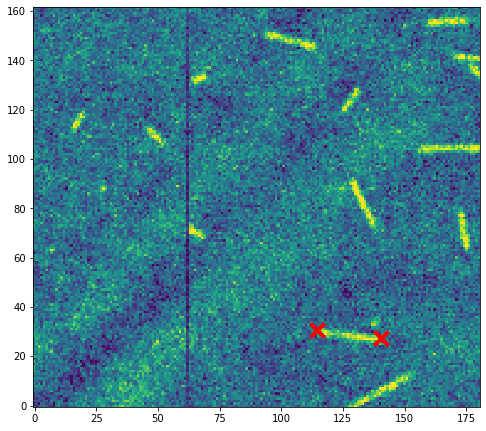

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(image[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(tip_start[1], tip_start[0], color='red', s=200, marker="x", lw=4)
ax.scatter(tip_end[1], tip_end[0], color='red', s=200, marker="x", lw=4)

## Define fitting parameters

In [44]:
# Define fitting parameters
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 1  # pixel
args['get_thick_line_args']['line_thickness'] = 5000 / metadata['pixel_size']  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.15
args['perpendicular_line_fit_args']['continuous_discard'] = False

args['offset_start'] = 4000 / metadata['pixel_size']  # pixel
args['offset_end'] = 2000 / metadata['pixel_size']  # pixel

args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 400 / metadata["pixel_size"]  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

## Iterate over all frames and do the fitting.

In [45]:
# Do the fitting
results = anamic.fitter.microtubule_tip_fitter(tip_start, tip_end, image, **args)
line_fit_tips, x_profile, y_profile, fit_result, fit_func = results
fit_values = fit_result.values
fit_values, fit_values['sigma'] * metadata['pixel_size']

({'mu': 40.72468260798625,
  'sigma': 0.934142987844728,
  'mt': 0.3760738955247178,
  'bg': 0.48071981227177374},
 102.75572866292009)

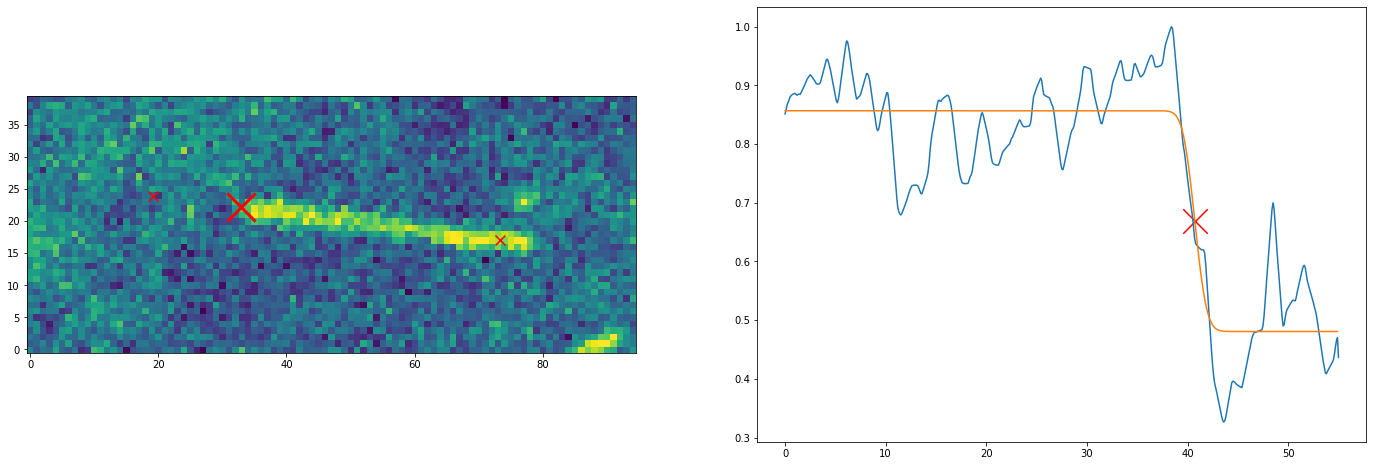

In [48]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 8))

ax1.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax1.set_aspect('equal')
ax1.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

ax2.plot(x_profile, y_profile, label='data')
ax2.plot(x, y_fitted, label='fit')
mu = fit_values['mu']
ax2.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

vec = line_fit_tips[1] - line_fit_tips[0]
x, y = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
ax1.scatter(y, x, color='red', s=800, marker='x', lw=3)

## Make movie with overlay

## Build kymograph